In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import scipy
import os

In [3]:
def load_data(img_path, msk_path, describe=True):
    img = np.load(img_path)['data']
    # only necessary if input is not already in an (x,y,z) format
    if os.path.splitext(msk_path.split('/')[-1])[0] == 'labels_train':
        msk = np.load(msk_path)['labels']
    if os.path.splitext(msk_path.split('/')[-1])[0] == 'boundaries':
        msk = np.load(msk_path)['boundaries']
     
    if describe:
        print(f'Image Shape: {img.shape} -- Image Min/Max: {(np.min(img), np.max(img))}')
        print(f'Mask Shape: {msk.shape} -- Mask Min/Max: {(np.min(msk), np.max(msk))}')
    
    return img, msk

dataset_all,labels_all = load_data(data_path, labels_path, describe = True)
dataset = dataset_all[int(dataset_all.shape[0]*(1-test_size)):,490:,:]
labels = labels_all[int(labels_all.shape[0]*(1-test_size)):,490:,:]

Image Shape: (782, 590, 1006) -- Image Min/Max: (-5195.5234, 5151.7188)
Mask Shape: (782, 590, 1006) -- Mask Min/Max: (1, 6)


In [4]:
data = dataset
print(data.shape)

(150, 150, 1006)


In [5]:
# Decrement masks values by 1 to stay consistent with 0 indexing in python.
labels = labels - 1
print(f'Labels min: {np.min(labels)} -- Labels max: {np.max(labels)}')

Labels min: 0 -- Labels max: 5


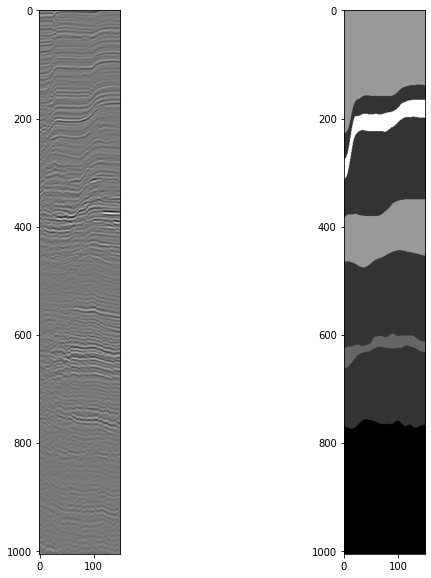

In [6]:
# Plot 2D slices of images and ground truth.
#image_slice = np.transpose(data,(2,0,1))[:,10,:]
#mask_slice = np.transpose(labels,(2,0,1))[:,10,:]
#fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
#axs[0].imshow(image_slice, cmap='gray')
#axs[1].imshow(mask_slice, cmap='gray')

In [8]:
def normalize_image_intensity(img):
    return (img - np.min(img))/(np.max(img) - np.min(img))

# Test normalizing function.
image_slice = data[:,:,20]
normalized_image = normalize_image_intensity(image_slice)
print(f'Min data value (regular): {np.min(image_slice)} -- Max data value (regular): {np.max(image_slice)}')
print(f'Min data value (normalized): {np.min(normalized_image)} -- Max data value (normalized): {np.max(normalized_image)}')

Min data value (regular): -773.477783203125 -- Max data value (regular): 635.428955078125
Min data value (normalized): 0.0 -- Max data value (normalized): 1.0


In [9]:
# Normalize volume.
data = normalize_image_intensity(data)
print(f'Min data value (normalized): {np.min(data)} -- Max data value (normalized): {np.max(data)}')

Min data value (normalized): 0.0 -- Max data value (normalized): 1.0


In [ ]:
#import numpy as np
#depthData = np.empty(data.shape)
#depthData = np.empty((10,10,10))
#for z in range(depthData.shape[2]):
#    depthData[:,:,z] = z

In [ ]:
# append depth info
#data = np.stack((data,depthData),axis=-1)
#data = [tf.expand_dims(x, axis=3) for x in data]
#print(data.shape)

In [10]:
#import math

def volume_slicer(img, msk, X, Y, Z):
    X1, Y1, Z1 = img.shape[0]//X, img.shape[1]//Y, img.shape[2]//Z
    print(f'Shapes in X1, Y1, Z1: ({X1}, {Y1}, {Z1})')
    img2 = []
    msk2 = []
    for x in range(0,img.shape[0],X1):
        for y in range(0,img.shape[1],Y1):
            for z in range(0,img.shape[2],Z1):
                img2.append(img[x:x+X1,y:y+Y1,z:z+Z1])
                msk2.append(msk[x:x+X1,y:y+Y1,z:z+Z1])
                
    return img2, msk2

# Function to split dataset according to dimensions.
def create_volumes_pipeline(img, msk, vol_size=(128,128,128), resize=True):
    X = round(img.shape[0]//vol_size[0])
    Y = round(img.shape[1]//vol_size[1])
    Z = round(img.shape[2]//vol_size[2])
    print(f'Samples in X, Y, Z: ({X}, {Y}, {Z})')
    sliced_data, sliced_mask = volume_slicer(img, msk, X, Y, Z)
    print(f'Total volume samples: {len(sliced_data)}')
    print(f'Data shape after slicing: {sliced_data[0].shape}')

    print(f'Total volume samples (Similarity test): {len(sliced_data)}')

    return sliced_data, sliced_mask

In [11]:
def trimVolume(img, vol_size):
    axisLen = [0,0,0]
    for i in range(3): #3 axes
        axisLen[i] = img.shape[i] - img.shape[i]%vol_size[i]
    return img[0:axisLen[0], 0:axisLen[1], 0:axisLen[2]]

In [12]:
print(data.shape)
data = trimVolume(data, [64,64,64])
labels = trimVolume(labels, [64,64,64])
print(data.shape)
print(labels.shape)

(150, 150, 1006)
(128, 128, 960)


In [13]:
# Test create_volumes_pipeline function.
curr_size = [64,64,64]
sliced_data, sliced_mask = create_volumes_pipeline(data, labels, vol_size=curr_size, resize=True)

Samples in X, Y, Z: (2, 2, 15)
Shapes in X1, Y1, Z1: (64, 64, 64)
Total volume samples: 60
Data shape after slicing: (64, 64, 64)
Total volume samples (Similarity test): 60


In [14]:
def volume_merger(msk, X, Y, Z, original_size):
    X1, Y1, Z1 = msk[0].shape[0], msk[0].shape[1], msk[0].shape[2]
    print(f'Shapes in X1, Y1, Z1: ({X1}, {Y1}, {Z1})')
    msk2 = np.empty(original_size)
    #img = [img[x:x+X1,y:y+Y1,z:z+Z1] for x in range(0,img.shape[0],X1) for y in range(0,img.shape[1],Y1) for z in range(0,img.shape[2],Z1)]
    #msk = [msk[x:x+X1,y:y+Y1,z:z+Z1] for x in range(0,msk.shape[0],X1) for y in range(0,msk.shape[1],Y1) for z in range(0,msk.shape[2],Z1)]
    vol_count = 0
    for x in range(0,original_size[0],X1):
        for y in range(0,original_size[1],Y1):
            for z in range(0,original_size[2],Z1):
                if msk[vol_count].shape != (X1,Y1,Z1):
                    print(msk[vol_count].shape)
                    print(vol_count)
                
                msk2[x:x+X1,y:y+Y1,z:z+Z1] = msk[vol_count]
                vol_count+=1
        
    return msk2

def merge_volumes(msk, original_size=(128,128,128)):
    X = (original_size[0]//msk[0].shape[0])
    Y = (original_size[1]//msk[0].shape[1])
    Z = (original_size[2]//msk[0].shape[2])
    print(f'Samples in X, Y, Z: ({X}, {Y}, {Z})')
    print(original_size)
    merged_mask = volume_merger(msk, X, Y, Z, original_size)
    print(f'Data shape after merging: {merged_mask.shape}')
    
    return merged_mask

In [15]:
#data2, labels2 = merge_volumes(sliced_data, sliced_mask, original_size=data.shape)

In [16]:
# Plot 2D slices of images and ground truth.
#image_slice = np.transpose(data,(2,0,1))[:,10,:]
#image2_slice = np.transpose(data2,(2,0,1))[:,10,:]
#fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
#axs[0].imshow(image_slice, cmap='gray')
#axs[1].imshow(image2_slice, cmap='gray')

In [17]:
# Free up space.#
#del data; del labels

In [18]:
# Plot upper left corner of sliced volume.
#image_slice = sliced_data[10][1,:,:]
#mask_slice = sliced_mask[10][1,:,:]
#fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
#axs[0].imshow(image_slice, cmap='gray')
#axs[1].imshow(mask_slice, cmap='gray')

In [19]:
#image_slice = input_data[59][:,:,1]
#mask_slice = input_masks[59][:,:,1]
#fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
#axs[0].imshow(image_slice, cmap='gray')
#axs[1].imshow(mask_slice, cmap='gray')

In [21]:
# Check sliced volume sizes and make sure they have the same dimensions.
def check_dimensions(img, msk, shape=curr_size, remove=True):
    test_array = np.zeros(shape)
    new_img, new_msk = img, msk
    if remove:
        new_img = [x for x in new_img if (x.shape == test_array.shape)]
        new_msk = [x for x in new_msk if (x.shape == test_array.shape)]

    print(f'{len(img) - len(new_img)} volumes removed due to incorrect dimensions.')
    return new_img, new_msk
        
# Remove any data that have dimensions not matching input size.
#input_data, input_masks = check_dimensions(sliced_data, sliced_mask)

0 volumes removed due to incorrect dimensions.


In [ ]:
input_data, input_masks = sliced_data, sliced_mask

In [22]:
# Add dimension to data and masks for convolutions.
input_data = [tf.expand_dims(x, axis=3) for x in input_data]
input_masks = [tf.expand_dims(x, axis=3) for x in input_masks]

In [ ]:
print(len(input_data))
print(input_data[0].shape)

In [ ]:
input_data = tf.convert_to_tensor(input_data)

In [ ]:
print(len(input_data))
print(input_data[0].shape)

In [ ]:
predictions = model.predict(input_data)

In [ ]:
print(len(predictions))
print(predictions[0].shape)

In [ ]:
#print(predictions)

In [ ]:
#convert prediction probabilities to list of labels for cubes
predicted_labels = []
num_pred = 0
for pred in predictions:
    
    cube = np.empty(box_size)
    
    cube = np.argmax(pred, axis=-1)
    predicted_labels.append(cube)
    num_pred+=1
    if num_pred%100==0 :
        print("Processed cubes: " + str(num_pred))
print(len(predicted_labels))
print(predicted_labels[0].shape)

In [ ]:
#data2 = merge_volumes(input_data, original_size=data.shape)
labels2 = merge_volumes(predicted_labels, original_size=labels.shape)

In [1]:
# Plot 2D slices.
image_slice = np.transpose(data,(2,0,1))[:,10,:]
#image2_slice = np.transpose(data2,(2,0,1,3))[:,10,:,0]
mask_slice = np.transpose(labels,(2,0,1))[:,10,:]
mask2_slice = np.transpose(labels2,(2,0,1))[:,10,:]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
axs[0,0].imshow(image_slice, cmap='gray')
axs[0,1].imshow(mask_slice, cmap='gray')
axs[1,0].imshow(mask_slice, cmap='gray')
axs[1,1].imshow(mask2_slice, cmap='gray')

NameError: name 'np' is not defined

In [ ]:
#image2_slice = np.transpose(data2,(2,0,1))[:,10,:]
#mask2_slice = np.transpose(labels2,(2,0,1))[:,10,:]
#fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
#axs[0].imshow(image2_slice, cmap='gray')
#xs[1].imshow(mask2_slice, cmap='gray')